In [36]:
import pandas as pd
import time
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
#Test
df = pd.DataFrame(data={'Item':['A','B','C','D'], 
                        'StartDate':pd.to_datetime(['2018-01-01','2018-01-07', '2017-12-30','2018-01-03']),
                        'EndDate': pd.to_datetime(['2018-01-04','2018-01-08','2018-01-05','2018-01-05']),
                        'RandomStuff':['sdfe','adfe','dafsdfew','fjt'],
                        'CT':[12,14,21,12]},
                 )

df['dayDiff'] = df.apply(lambda avg: avg['CT']/((avg['EndDate']-avg['StartDate']).days +1),axis=1)
#print(df)


In [3]:
start = time.time()

new_df = df.apply(lambda x: pd.Series(
        {
        'avg':x['CT']/((x['EndDate']-x['StartDate']).days +1),
        'item':x['Item'],
        'date_range':pd.date_range(x['StartDate'],x['EndDate'])
        }), 
    axis=1).set_index(['item','avg'])['date_range'].apply(pd.Series).stack().reset_index().drop('level_2',axis=1)

print(time.time()-start)
new_df

0.015782833099365234


,item,avg,0
0,A,3.0,2018-01-01
1,A,3.0,2018-01-02
2,A,3.0,2018-01-03
3,A,3.0,2018-01-04
4,B,7.0,2018-01-07
5,B,7.0,2018-01-08
6,C,3.0,2017-12-30
7,C,3.0,2017-12-31
8,C,3.0,2018-01-01
9,C,3.0,2018-01-02


In [4]:
all_item = list(set(df['Item']))

In [5]:
start = time.time()

# df = df.copy()
index = pd.MultiIndex.from_product([all_item,pd.date_range(start = df.StartDate.min(), end = df.EndDate.max())], names=['Item', 'date'])
ori_df = pd.DataFrame(index = index, data = {'counts':0})

dates_list = ori_df.index.get_level_values(1)
items_list = ori_df.index.get_level_values(0)

for row in df.itertuples():
    ori_df.counts[(items_list == row.Item) & (dates_list>=row.StartDate) & (dates_list<= row.EndDate)] += row[6]

# to remove 0 if needed
ori_df = ori_df[(ori_df.counts != 0)]

ori_df.reset_index(inplace=True)

print(time.time()-start)
ori_df

0.023848295211791992


,Item,date,counts
0,A,2018-01-01,3
1,A,2018-01-02,3
2,A,2018-01-03,3
3,A,2018-01-04,3
4,D,2018-01-03,4
5,D,2018-01-04,4
6,D,2018-01-05,4
7,B,2018-01-07,7
8,B,2018-01-08,7
9,C,2017-12-30,3


In [6]:
ori_df = pd.merge(ori_df, df, how='inner', on='Item')
ori_df

,Item,date,counts,StartDate,EndDate,RandomStuff,CT,dayDiff
0,A,2018-01-01,3,2018-01-01,2018-01-04,sdfe,12,3.0
1,A,2018-01-02,3,2018-01-01,2018-01-04,sdfe,12,3.0
2,A,2018-01-03,3,2018-01-01,2018-01-04,sdfe,12,3.0
3,A,2018-01-04,3,2018-01-01,2018-01-04,sdfe,12,3.0
4,D,2018-01-03,4,2018-01-03,2018-01-05,fjt,12,4.0
5,D,2018-01-04,4,2018-01-03,2018-01-05,fjt,12,4.0
6,D,2018-01-05,4,2018-01-03,2018-01-05,fjt,12,4.0
7,B,2018-01-07,7,2018-01-07,2018-01-08,adfe,14,7.0
8,B,2018-01-08,7,2018-01-07,2018-01-08,adfe,14,7.0
9,C,2017-12-30,3,2017-12-30,2018-01-05,dafsdfew,21,3.0


In [7]:
#Test
def sprint_parse(text):
    sprint = re.search('sprint \d*\.?\d*', text.lower())
    if sprint is None:
        return 0
    else:
        #return re.sub('[a-z]', '', sprint.group(0))
        return pd.to_numeric(re.sub("[a-z]", "", sprint.group(0)), errors='coerce')

ndf = pd.DataFrame(data={'Item':['A','B','C','D'], 
                        'StartDate':pd.to_datetime(['2018-01-01','2018-01-07', '2017-12-30','2018-01-03']),
                        'EndDate': pd.to_datetime(['2018-01-04','2018-01-08','2018-01-05','2018-01-05']),
                        'RandomStuff':['12 sprint 1','sprint 12 13.4','R3 sprint 13.3 t', 'xxxxx'],
                        'CT':[12,14,21,12]},
                 )

ndf.RandomStuff = ndf['RandomStuff'].apply(sprint_parse)
ndf.rename(columns={'Item': '0'}, index=str)
ndf


,Item,StartDate,EndDate,RandomStuff,CT
0,A,2018-01-01,2018-01-04,1.0,12
1,B,2018-01-07,2018-01-08,12.0,14
2,C,2017-12-30,2018-01-05,13.3,21
3,D,2018-01-03,2018-01-05,0.0,12


In [8]:
# Test for subgrouping
df2 = pd.DataFrame(data={'Item':['A','A','A','B','B','C','C','C','C','D'], 
                        'NumPer': ['1','3','6','2','2','1','1','1','1','8']})
df2['itemTot'] = df2.groupby('Item').NumPer.transform(np.sum)
df2
#pd.merge(df2, 
#         df2.groupby(by='Item').sum().rename(columns={'NumPer':'totSprintTime'}), 
#         how='inner', on='Item')

,Item,NumPer,itemTot
0,A,1,136
1,A,3,136
2,A,6,136
3,B,2,22
4,B,2,22
5,C,1,1111
6,C,1,1111
7,C,1,1111
8,C,1,1111
9,D,8,8


In [9]:
df3 = pd.DataFrame(data={'Item':['A','B','C'], 
                        'NumPer': ['1','3','6'], 
                        'SubItem': ['hello; there','some','hello; there; some']})

#df3['SubItem'] = df3['SubItem'].str.split("; ")

df3['SubItem'].str.split("; ").apply(pd.Series) \
    .merge(df3, left_index = True, right_index = True) \
    .drop(["SubItem"], axis = 1) \
    .melt(id_vars = ['Item', 'NumPer'], value_name = "subitem")\
    .drop("variable", axis = 1) \
    .dropna()

,Item,NumPer,subitem
0,A,1,hello
1,B,3,some
2,C,6,hello
3,A,1,there
5,C,6,there
8,C,6,some


In [50]:
df5 = pd.DataFrame(data={'Item':['A','A','A','B','B','C','C','C','C','D'], 
                        'NumPer': [1,3,6,2,2,1,1,1,1,8],
                        'Hrs': [3,2,8,2,1,9,6,2,4,2]})

df5['weightRaw'] = (df5['Hrs']/df5.groupby('Item').Hrs.transform("sum") * df5['NumPer']/df5['Hrs'])
df6 = df5.groupby('Item')['weightRaw','Hrs'].apply(sum).reset_index()
df6

,Item,weightRaw,Hrs
0,A,0.769231,13.0
1,B,1.333333,3.0
2,C,0.190476,21.0
3,D,4.000000,2.0


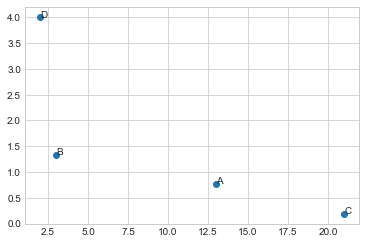

In [51]:
plt.scatter(df6['Hrs'], df6['weightRaw'], marker='o')
for i, txt in enumerate(df6.Item):
    plt.annotate(txt, (df6['Hrs'][i], df6['weightRaw'][i]))